In [42]:
# train_per_county.ipynb

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# ---------------------------
# 1. Load local Zillow CSV
# ---------------------------
csv_path = "../data/zillow_county.csv"  # <-- update this path
df_all = pd.read_csv(csv_path, low_memory=False)

# Focus only on California counties
df_ca = df_all[df_all["StateName"] == "CA"].copy()
print("California subset shape:", df_ca.shape)


California subset shape: (58, 315)


In [37]:
def prepare_data(county_df, lags=12):
    ts = county_df.drop(columns=["RegionID","SizeRank","RegionName","StateName","State","Metro","StateCodeFIPS"], errors="ignore").T
    ts.columns = ["Price"]
    ts = ts.dropna()

    data = pd.DataFrame()
    for i in range(lags, 0, -1):
        data[f"lag_{i}"] = ts["Price"].shift(i)
    data["target"] = ts["Price"]
    data = data.dropna()
    return ts, data


In [43]:
def prepare_data(county_df, lags=12):
    # Identify only the date columns (they look like YYYY-MM)
    date_cols = [c for c in county_df.columns if c[:4].isdigit()]
    if not date_cols:
        raise ValueError("No date columns found in county_df! Check the county name.")

    ts = county_df[date_cols].T
    ts.columns = ["Price"]
    ts.index = pd.to_datetime(ts.index)  # convert YYYY-MM strings to datetime

    ts = ts.dropna()

    # Build supervised learning data with lag features
    data = pd.DataFrame()
    for i in range(lags, 0, -1):
        data[f"lag_{i}"] = ts["Price"].shift(i)
    data["target"] = ts["Price"]
    data = data.dropna()
    return ts, data

county = "Santa Clara County"
county_df = df_ca[df_ca["RegionName"] == county]
print("Columns:", county_df.columns[:20])  # print first 20 column names
print("Shape:", county_df.shape)


Columns: Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS', '2000-01-31',
       '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30',
       '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30'],
      dtype='object')
Shape: (1, 315)


In [44]:
# What counties are in California in your dataset?
print(df_ca["RegionName"].unique()[:50])  # first 50
print("Total counties in California:", len(df_ca["RegionName"].unique()))


['Los Angeles County' 'San Diego County' 'Orange County'
 'Riverside County' 'San Bernardino County' 'Santa Clara County'
 'Alameda County' 'Sacramento County' 'Contra Costa County'
 'Fresno County' 'Kern County' 'San Francisco County' 'Ventura County'
 'San Joaquin County' 'San Mateo County' 'Stanislaus County'
 'Sonoma County' 'Tulare County' 'Solano County' 'Santa Barbara County'
 'Monterey County' 'Placer County' 'San Luis Obispo County'
 'Merced County' 'Santa Cruz County' 'Marin County' 'Butte County'
 'Yolo County' 'El Dorado County' 'Shasta County' 'Imperial County'
 'Madera County' 'Kings County' 'Napa County' 'Humboldt County'
 'Nevada County' 'Sutter County' 'Mendocino County' 'Yuba County'
 'Lake County' 'Tehama County' 'San Benito County' 'Tuolumne County'
 'Calaveras County' 'Siskiyou County' 'Amador County' 'Lassen County'
 'Glenn County' 'Del Norte County' 'Colusa County']
Total counties in California: 58


In [45]:
print(df_all.columns[:30])   # first 30 column names
print(df_all.head(3))        # peek first 3 rows


Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS', '2000-01-31',
       '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30',
       '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30',
       '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
       '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31', '2001-09-30'],
      dtype='object')
   RegionID  SizeRank          RegionName RegionType StateName State  \
0      3101         0  Los Angeles County     county        CA    CA   
1       139         1         Cook County     county        IL    IL   
2      1090         2       Harris County     county        TX    TX   

                                  Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0    Los Angeles-Long Beach-Anaheim, CA              6                 37   
1    Chicago-Naperville-Elgin, IL-IN-WI             17                 31   


Santa Clara County series length: 306 months


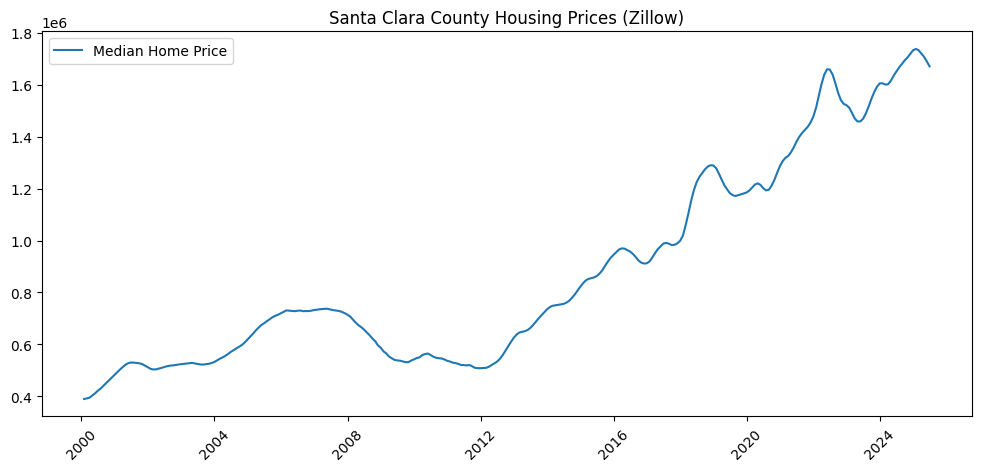

In [46]:

# Prepare data
ts, data = prepare_data(county_df, lags=12)
print(f"{county} series length: {len(ts)} months")

# Plot historical price series
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts["Price"], label="Median Home Price")
plt.title(f"{county} Housing Prices (Zillow)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [47]:
X = data.drop(columns=["target"]).values
y = data["target"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

split = int(len(X_scaled)*0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]


c:\Users\lina_76\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


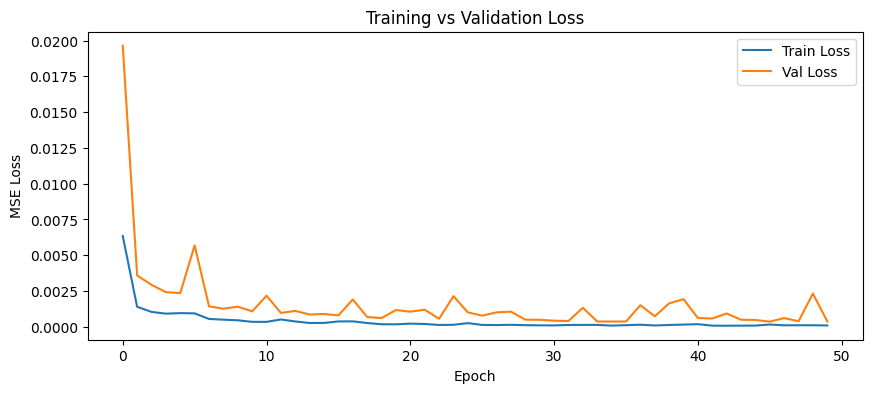

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=8, verbose=0
)

# Plot training loss
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


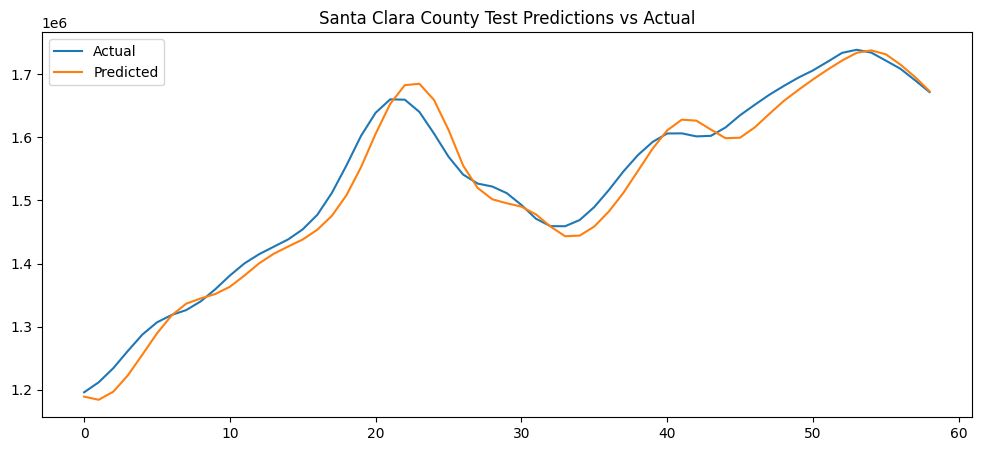

In [49]:
# Evaluate
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_true = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title(f"{county} Test Predictions vs Actual")
plt.legend()
plt.show()

# Forecast next 6 months
last_window = X_scaled[-1].reshape(1,-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

📈 Next 6 Months Forecast:
     Month  Predicted Price
0  2025-07        1672975.0
1  2025-08        1652502.0
2  2025-09        1629400.0
3  2025-10        1608091.0
4  2025-11        1587001.0
5  2025-12        1565847.0


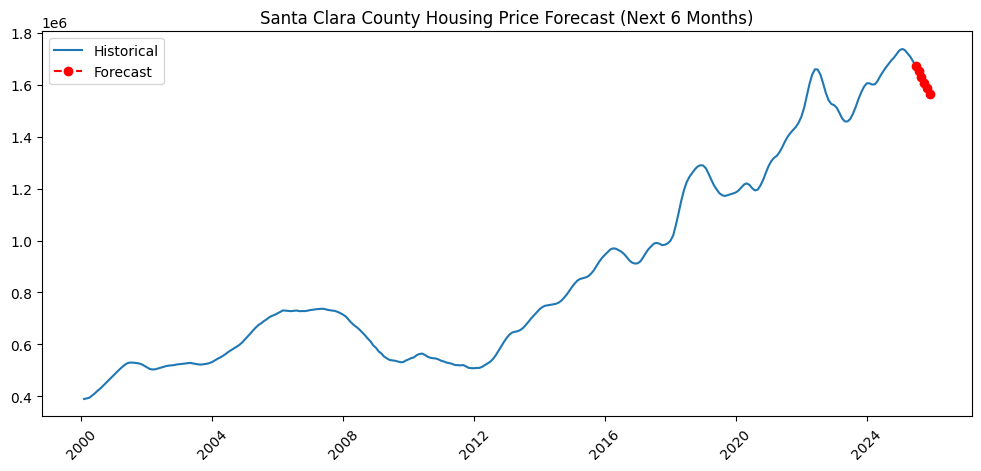

In [50]:

# --- Forecast next 6 months ---
last_window = X_scaled[-1].reshape(1, -1)
future_preds = []

for _ in range(6):
    next_scaled = model.predict(last_window)
    next_value = scaler_y.inverse_transform(next_scaled)[0][0]
    future_preds.append(next_value)

    # roll the window and insert the new prediction
    last_window = np.roll(last_window, -1)
    last_window[0, -1] = next_scaled

# --- Build month labels ---
last_date = ts.index[-1]   # last date from historical time series
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=6, freq="MS")

forecast_df = pd.DataFrame({
    "Month": future_dates.strftime("%Y-%m"),
    "Predicted Price": np.round(future_preds, 0)
})

print("\n📈 Next 6 Months Forecast:")
print(forecast_df)

# --- Plot history + forecast ---
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts["Price"], label="Historical")
plt.plot(future_dates, future_preds, "o--", color="red", label="Forecast")
plt.title(f"{county} Housing Price Forecast (Next 6 Months)")
plt.xticks(rotation=45)
plt.legend()
plt.show()


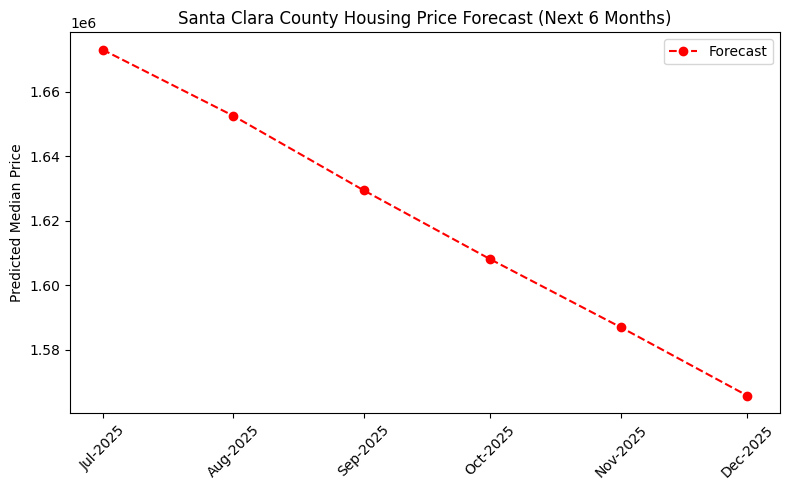

In [51]:
# --- Clean future-only plot ---
plt.figure(figsize=(8,5))
plt.plot(future_dates, future_preds, "o--", color="red", label="Forecast")

plt.title(f"{county} Housing Price Forecast (Next 6 Months)")
plt.ylabel("Predicted Median Price")

# Format x-axis as "Month-Year"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
